By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
regions = 'paired_hl' # 'paired_hl' or 'heavy'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']

preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

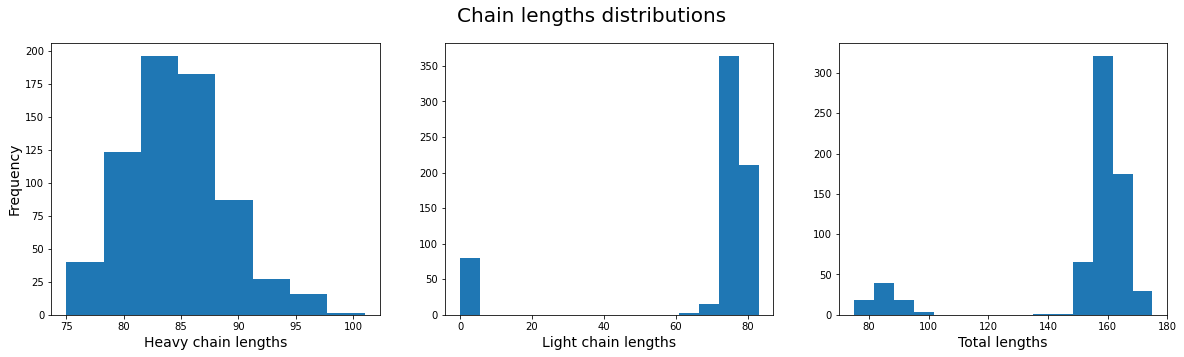

In [3]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

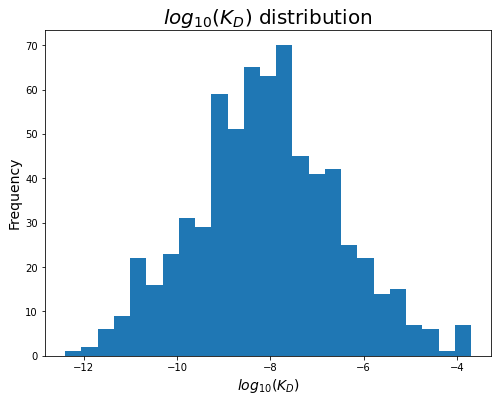

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

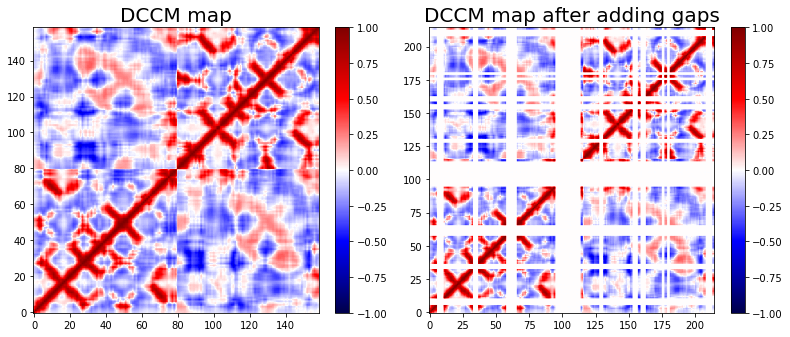

In [5]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [6]:
# The test set is generated
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [7]:
# Hyperparameters
n_filters = 3
filter_size = 5
pooling_size = 2
learning_rate = 0.00027253018778843 * 3

# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss() #-PearsonCorrCoef()
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=33075, out_features=1, bias=False)
)


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
#{'learning_rate': 0.00027253018778843, 'n_max_epochs': 65, 'pooling_size': 1, 'filter_size': 4, 'n_filters': 4}
#{'learning_rate': 0.0008657756272162166, 'n_max_epochs': 82, 'pooling_size': 1, 'filter_size': 5, 'n_filters': 1}. Best is trial 30 with value: 1.0617385705312092.

# Training

In [10]:
train_losses = []
test_losses = []

In [31]:
n_max_epochs = 100
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor([[-8.6483]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6729]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.5967]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.5844]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3360]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.3092]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.5639]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.3543]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.1392]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.8341]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8783]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.1319]], grad_fn=<MmBack

tensor([[-9.2893]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5326]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7039]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6588]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.9773]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.2289]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-5.9782]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.5414]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.3773]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.9955]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8367]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.9371]], grad_fn=<MmBack

tensor([[-9.3609]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4416]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4521]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.4771]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.4651]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.3687]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.6087]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.5630]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.5633]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.0533]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.2769]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.1472]], grad_fn=<MmBack

tensor([[-9.5044]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.2793]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1787]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.8003]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3733]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5062]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.5703]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4931]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4052]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.9118]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0251]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.8785]], grad_fn=<MmBack

tensor([[-9.7054]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6429]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7354]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.3994]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3885]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5488]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.7028]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.1001]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.1221]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.0634]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.2243]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.2371]], grad_fn=<MmBack

tensor([[-9.3900]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.7109]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1887]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.7532]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.2971]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.3908]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.6939]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9140]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.6541]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.6841]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.2667]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.0481]], grad_fn=<MmBack

tensor([[-9.4651]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5020]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.6806]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.0414]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.5106]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.9668]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.5289]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.8311]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7204]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.3248]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9228]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.8189]], grad_fn=<MmBack

tensor([[-9.0773]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6943]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.6226]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.7278]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.4820]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5203]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.7218]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.4588]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4173]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.1139]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.3671]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.0103]], grad_fn=<MmBack

tensor([[-9.5097]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.3890]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4468]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.7220]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.8150]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5193]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.3828]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.5270]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.8340]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.7981]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8760]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.3744]], grad_fn=<MmBack

tensor([[-9.5036]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5454]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1058]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.2367]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.5725]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.6197]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.0868]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.0299]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.1287]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.1642]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8870]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.9051]], grad_fn=<MmBack

tensor([[-9.7767]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6831]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3351]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.0530]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.4041]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.2417]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.4441]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9434]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.8317]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.1153]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0442]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.0400]], grad_fn=<MmBack

tensor([[-9.1603]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.3006]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4888]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.5266]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3762]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.3574]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.7089]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.7280]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4451]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.1928]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0798]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.8953]], grad_fn=<MmBack

tensor([[-9.2697]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.3339]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2409]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.8261]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.8854]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.3861]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.0814]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.7420]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4528]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.4315]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0494]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.5144]], grad_fn=<MmBack

tensor([[-9.0924]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6620]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2542]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6426]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.5929]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.1815]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.0209]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.6267]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7297]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.2586]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.7705]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.3229]], grad_fn=<MmBack

tensor([[-9.3317]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4900]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.5343]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.0000]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.0491]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.0802]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.2126]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.7288]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.5227]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.0857]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.4506]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.2176]], grad_fn=<MmBack

tensor([[-9.1990]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.2512]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3303]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.5994]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.0163]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.6617]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.1107]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.6232]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.2951]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.9410]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1558]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.2716]], grad_fn=<MmBack

tensor([[-9.4246]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.2653]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4658]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9130]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.7541]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.1758]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.5901]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9813]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.1557]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-4.4245]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8158]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.3507]], grad_fn=<MmBack

In [27]:
#optimiser.param_groups[0]['lr'] = 5e-4

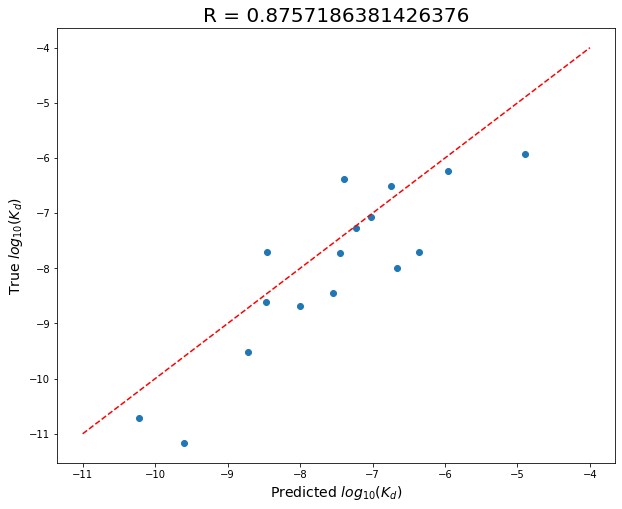

In [28]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(output_test[:,0].detach().numpy(), y_test[:,0].detach().numpy())
corr = np.corrcoef(output_test[:,0].detach().numpy().T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

In [30]:
y_test[:,0].detach().numpy()

array([[-11.167491 ],
       [ -7.7212462],
       [ -7.275724 ],
       [ -6.3809066],
       [ -7.0772743],
       [ -9.522879 ],
       [ -8.       ],
       [ -8.447331 ],
       [ -8.60206  ],
       [ -5.920819 ],
       [ -6.229148 ],
       [ -6.5086384],
       [-10.707744 ],
       [ -7.69897  ],
       [ -7.69897  ],
       [ -8.686132 ]], dtype=float32)

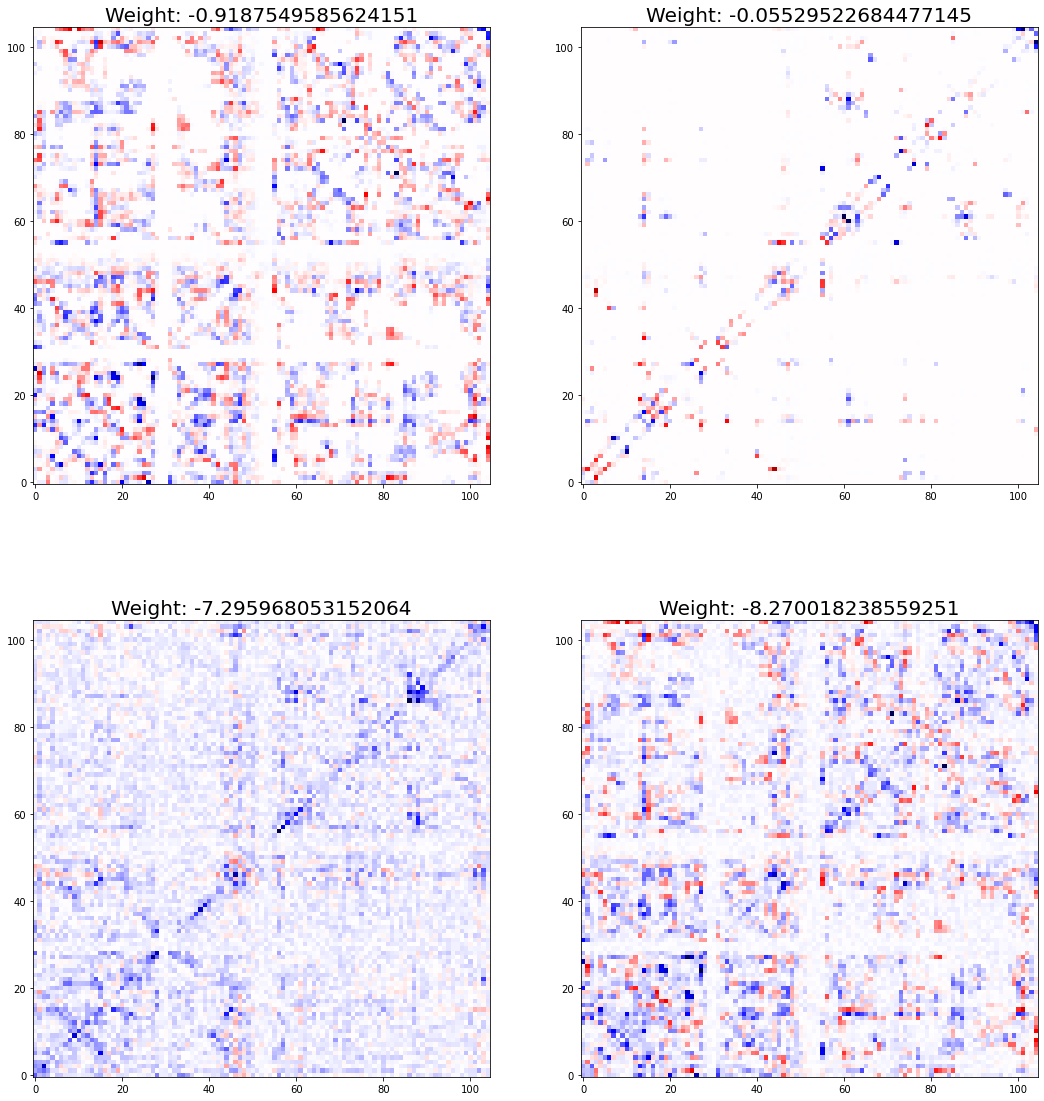

In [23]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[i,j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[i,j].set_title('Weight: '+str(im_.sum()), size=title_size)

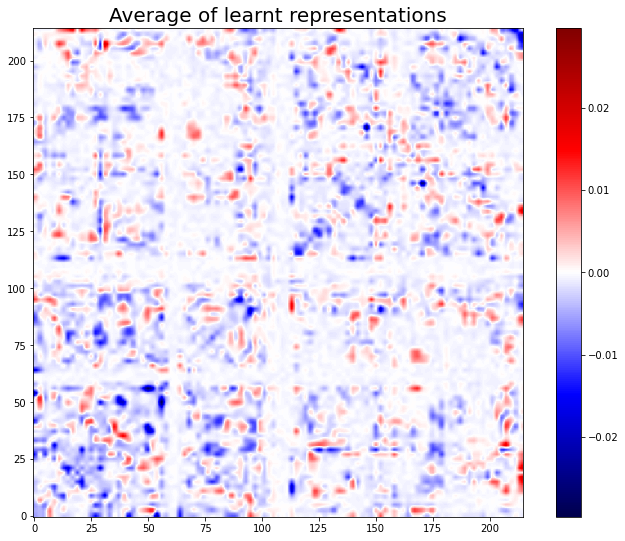

In [24]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(cv2.resize(learnt_filter, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

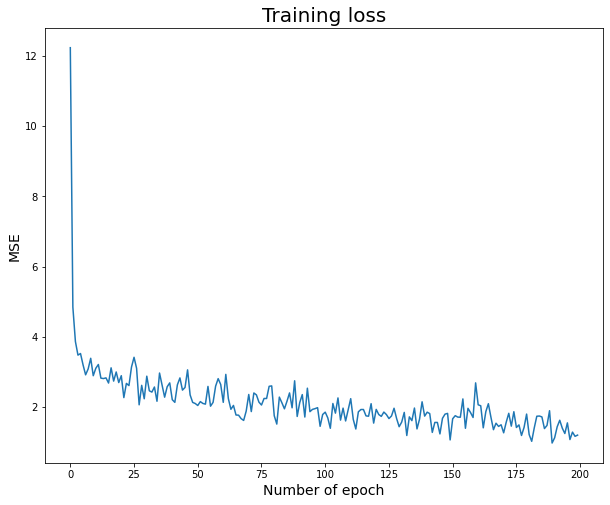

In [25]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

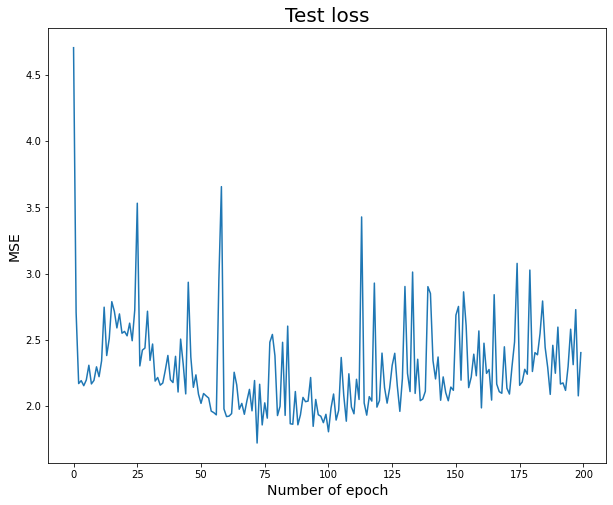

In [26]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i].detach().numpy() for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

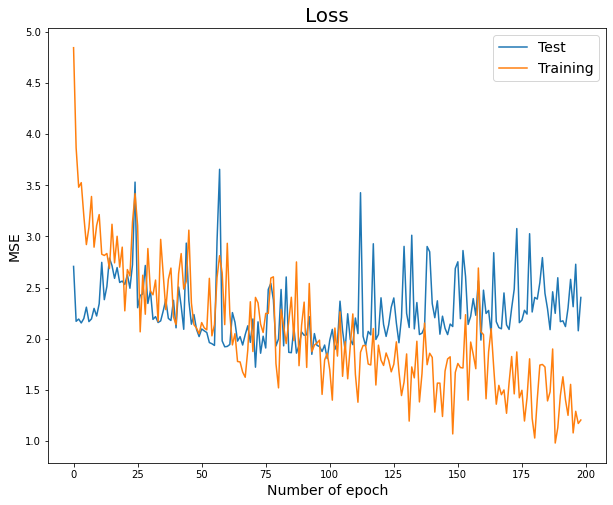

In [27]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[1:][i].detach().numpy() for i in range(len(test_losses[1:]))])
plt.plot([train_losses[1:][i] for i in range(len(train_losses[1:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [162]:
model(train_x[40:80])[0]

tensor([[ -8.4265],
        [ -7.6718],
        [ -7.5002],
        [ -6.9055],
        [ -7.1179],
        [ -7.2074],
        [ -7.6958],
        [ -8.1247],
        [-10.5261],
        [ -8.3590],
        [ -8.6381],
        [ -9.2110],
        [ -9.1186],
        [ -9.2002],
        [ -8.5722],
        [ -8.3909],
        [ -7.3118],
        [ -7.5973],
        [ -8.2262],
        [ -7.9762],
        [ -7.4702],
        [-10.8793],
        [ -8.3603],
        [ -8.6248],
        [ -7.2801],
        [ -8.4378],
        [ -7.1501],
        [ -7.3096],
        [ -7.1187],
        [ -9.1540],
        [ -6.6432],
        [ -5.4261],
        [ -8.2994],
        [ -9.9867],
        [ -6.0989],
        [ -6.8518],
        [ -8.5852],
        [ -5.4756],
        [ -7.2051],
        [ -6.8613]], grad_fn=<MmBackward0>)

In [135]:
train_y[40:80]

tensor([[ -9.0269],
        [ -6.7905],
        [ -9.1759],
        [ -5.3098],
        [ -7.0269],
        [ -6.8539],
        [ -5.7959],
        [ -8.4815],
        [-10.7447],
        [ -8.7645],
        [ -8.5935],
        [ -9.5686],
        [-11.6021],
        [ -8.3010],
        [ -8.2218],
        [ -7.0605],
        [ -6.7799],
        [ -7.7212],
        [ -8.2218],
        [ -8.1871],
        [ -8.1141],
        [-11.2441],
        [ -7.6576],
        [ -9.5376],
        [ -7.3279],
        [ -6.6198],
        [ -6.5391],
        [ -7.8539],
        [ -7.7696],
        [ -8.2518],
        [ -7.0000],
        [ -5.3279],
        [ -6.3872],
        [-10.2676],
        [ -5.0555],
        [ -5.7959],
        [ -8.2147],
        [ -4.6198],
        [ -7.5528],
        [ -6.2218]])

In [ ]:
##### Uncomment the following lines to save a checkpoint

#path = '../checkpoints/model_' + regions + '_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
#save_checkpoint(path, model, optimiser, train_losses, test_losses)
#np.save('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [24]:
##### Uncomment the following lines to load a checkpoint

from antipasti.utils.torch_utils import load_checkpoint
#
path = '../checkpoints/model_' + regions + '_epochs_' + str(235) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model,_,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
